In [1]:
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GradExplainer, GNNExplainer, PGMExplainer, GraphLIME
from graphxai.metrics.base import graph_exp_acc, graph_exp_faith
from torch_geometric.utils import k_hop_subgraph
from graphxai.utils import Explanation, EnclosingSubgraph
import matplotlib.pyplot as plt
from torch_geometric.data import Data

c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Generate dataset ShapeGGen
dataset = ShapeGGen(
    model_layers = 3,
    num_subgraphs = 8,
    subgraph_size = 5,
    prob_connection = 0.3,
    add_sensitive_feature = False
)

# Ambil graph dari dataset
data = dataset.graph  # Dataset hanya memiliki satu graf
explanation = dataset.explanations  # atau mungkin dataset.explanations jika atributnya berbentuk list

print(f"Graph Data: {data}")
print(f"Graph Explanations: {explanation}")
print(f"Explanation Available: {'Yes' if explanation is not None else 'No'}")

100%|██████████| 16/16 [00:00<00:00, 277.93it/s]

Graph Data: Data(x=[40, 10], edge_index=[2, 128], y=[40], shape=[40])
Graph Explanations: [[<graphxai.utils.explanation.Explanation object at 0x000002A190933FA0>], [<graphxai.utils.explanation.Explanation object at 0x000002A1F66A7520>], [<graphxai.utils.explanation.Explanation object at 0x000002A19094DCA0>], [<graphxai.utils.explanation.Explanation object at 0x000002A19094D1F0>], [<graphxai.utils.explanation.Explanation object at 0x000002A19094D280>], [<graphxai.utils.explanation.Explanation object at 0x000002A19094DC70>], [<graphxai.utils.explanation.Explanation object at 0x000002A19094D700>], [<graphxai.utils.explanation.Explanation object at 0x000002A19094D730>], [<graphxai.utils.explanation.Explanation object at 0x000002A19094D820>], [<graphxai.utils.explanation.Explanation object at 0x000002A19094DA00>], [<graphxai.utils.explanation.Explanation object at 0x000002A19094D910>], [<graphxai.utils.explanation.Explanation object at 0x000002A19094D8B0>], [<graphxai.utils.explanation.Expl

In [3]:
print(data.keys)

['x', 'shape', 'y', 'edge_index']


In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn.functional as F
from graphxai.gnn_models.node_classification import GCN, train, test

# Asumsi data ShapeGGen tersedia di dataset.graph
data = dataset.get_graph(use_fixed_split=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(torch.unique(data.y)) 

# Inisialisasi model dan optimizer
model = GCN(hidden_channels=32, input_feat=dataset.n_features, classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Hitung bobot berdasarkan distribusi label
class_weights = compute_class_weight('balanced', classes=np.unique(data.y.cpu()), y=data.y.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Gunakan saat inisialisasi loss function
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

for epoch in range(300):
    loss = train(model, optimizer, criterion, data)

f1, acc, prec, rec, auprc, auroc = test(model, data, num_classes=num_classes, get_auc=True)

print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))


Test F1 score: 0.9412
Test AUROC: 1.0000


In [5]:
print(torch.bincount(data.y))


tensor([ 8, 32])


In [23]:
class SafeGraphLIME(GraphLIME):
    def get_explanation_node(self, node_idx, x, edge_index, *args, **kwargs):
        # Pastikan model ada di device yang benar (kalau CPU/GPU beda)
        self.model = self.model.to(x.device)

        # Panggil GraphLIME asli, tapi log sebelum dan sesudah
        print(f"[SafeGraphLIME] Memulai explain node {node_idx}")
        result = super().get_explanation_node(node_idx, edge_index, x, *args, **kwargs)
        print(f"[SafeGraphLIME] Selesai explain node {node_idx}")

        return result


# Inisialisasi explainer
grad_explainer = GradExplainer(model, criterion=F.nll_loss)
gnn_explainer = GNNExplainer(model)
pgm_explainer = PGMExplainer(model, explain_graph=False)
lime_explainer = SafeGraphLIME(model)

# Ambil satu node untuk dijelaskan
node_idx = 10  # Pastikan node ini valid dan ada di train mask
x, edge_index = data.x, data.edge_index
# === Ambil Subgraph k-hop (khusus Grad dan GNN) ===
num_hops = 2
subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx, num_hops, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes
)
sub_x = data.x[subset]

# Grad dan GNN pakai subgraph
grad_explanation = grad_explainer.get_explanation_node(mapping, sub_x, sub_edge_index)
gnn_explanation = gnn_explainer.get_explanation_node(mapping, sub_x, sub_edge_index)

# PGM dan GraphLIME pakai full graph
x, edge_index = dataset.graph.x, dataset.graph.edge_index
print(f"Check sebelum GraphLIME:")
print(f"x shape: {x.shape}")
print(f"edge_index shape: {edge_index.shape}")
print(f"edge_index max node id: {edge_index.max().item()}")

assert x.shape[0] > edge_index.max().item(), "Jumlah node di x tidak sesuai edge_index!"

pgm_explanation = pgm_explainer.get_explanation_node(node_idx, x, edge_index)
lime_explanation = lime_explainer.get_explanation_node(node_idx, x, edge_index)


Check sebelum GraphLIME:
x shape: torch.Size([40, 10])
edge_index shape: torch.Size([2, 128])
edge_index max node id: 39


  0%|          | 0/1000000 [00:00<?, ?it/s]

[SafeGraphLIME] Memulai explain node 10
[SafeGraphLIME] Selesai explain node 10



c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [24]:
# Ground truth explanation dari ShapeGGen
ground_truth = dataset.explanations[node_idx][0]  # Extract the Explanation object from the list

# Evaluasi Graph Explanation Accuracy (GEA)
gea_grad = graph_exp_acc(ground_truth, grad_explanation)
gea_gnn = graph_exp_acc(ground_truth, gnn_explanation)
gea_pgm = graph_exp_acc(ground_truth, pgm_explanation)
# khusus LIME (karena lebih ke feature importance bukan node jadi di konversi ke node)
# Dapatkan feature importance dari GraphLIME
lime_explanation = lime_explainer.get_explanation_node(node_idx, x, edge_index)

# Konversi feature importance GraphLIME ke node importance
node_importance = lime_explanation.feature_imp.mean().item()
lime_node_importance = torch.zeros(data.num_nodes)  # Untuk full graph
lime_node_importance[node_idx] = node_importance

# Buat node_reference lengkap untuk full graph
node_reference = {i: i for i in range(data.num_nodes)}

# Buat edge_mask manual (untuk mendukung versi lama torch_geometric)
edge_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
for edge_id, (src, dst) in enumerate(data.edge_index.T):
    if src in subset and dst in subset:
        edge_mask[edge_id] = True

class ExplanationCompat(Explanation):
    def __init__(self, enc_subgraph=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.enc_subgraph = enc_subgraph

lime_exp = ExplanationCompat(
    node_imp=lime_node_importance,
    node_idx=node_idx,
    enc_subgraph=EnclosingSubgraph(
        nodes=subset,
        edge_index=sub_edge_index,
        inv=mapping,
        edge_mask=edge_mask,
        directed=False
    )
)

lime_exp.node_reference = node_reference  # Ini kunci utama!
gea_lime = graph_exp_acc(ground_truth, lime_exp)

print("Graph Explanation Accuracy:")
print(f"Grad: {gea_grad:.4f}")
print(f"GNNExplainer: {gea_gnn:.4f}")
print(f"PGMExplainer: {gea_pgm:.4f}")
print(f"GraphLIME: {gea_lime:.4f}")

# Evaluasi Graph Explanation Faithfulness (GEF)
gef_grad = graph_exp_faith(grad_explanation, dataset, model)
gef_gnn = graph_exp_faith(gnn_explanation, dataset, model)
gef_pgm = graph_exp_faith(pgm_explanation, dataset, model)
gef_lime = graph_exp_faith(lime_exp, dataset, model)
print("\nGraph Explanation Faithfulness:")
print(f"Grad: {gef_grad:.4f}")
print(f"GNNExplainer: {gef_gnn:.4f}")
print(f"PGMExplainer: {gef_pgm:.4f}")
print(f"GraphLIME: {gef_lime:.4f}")

[SafeGraphLIME] Memulai explain node 10
[SafeGraphLIME] Selesai explain node 10
Graph Explanation Accuracy:
Grad: 0.0000
GNNExplainer: 0.0000
PGMExplainer: 0.0000
GraphLIME: 0.0000

Graph Explanation Faithfulness:
Grad: 0.9979
GNNExplainer: 0.9979
PGMExplainer: 0.9975
GraphLIME: 0.8259


c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [25]:
print('GradExplainer node_idx:', grad_explanation.node_idx)
print('GNNExplainer node_idx:', gnn_explanation.node_idx)
print('GraphLIME node_idx:', lime_explanation.node_idx)
print('PGMExplainer node_idx:', pgm_explanation.node_idx)
print('Ground truth node_idx:', node_idx)

GradExplainer node_idx: tensor([0])
GNNExplainer node_idx: tensor([0])
GraphLIME node_idx: 10
PGMExplainer node_idx: 10
Ground truth node_idx: 10


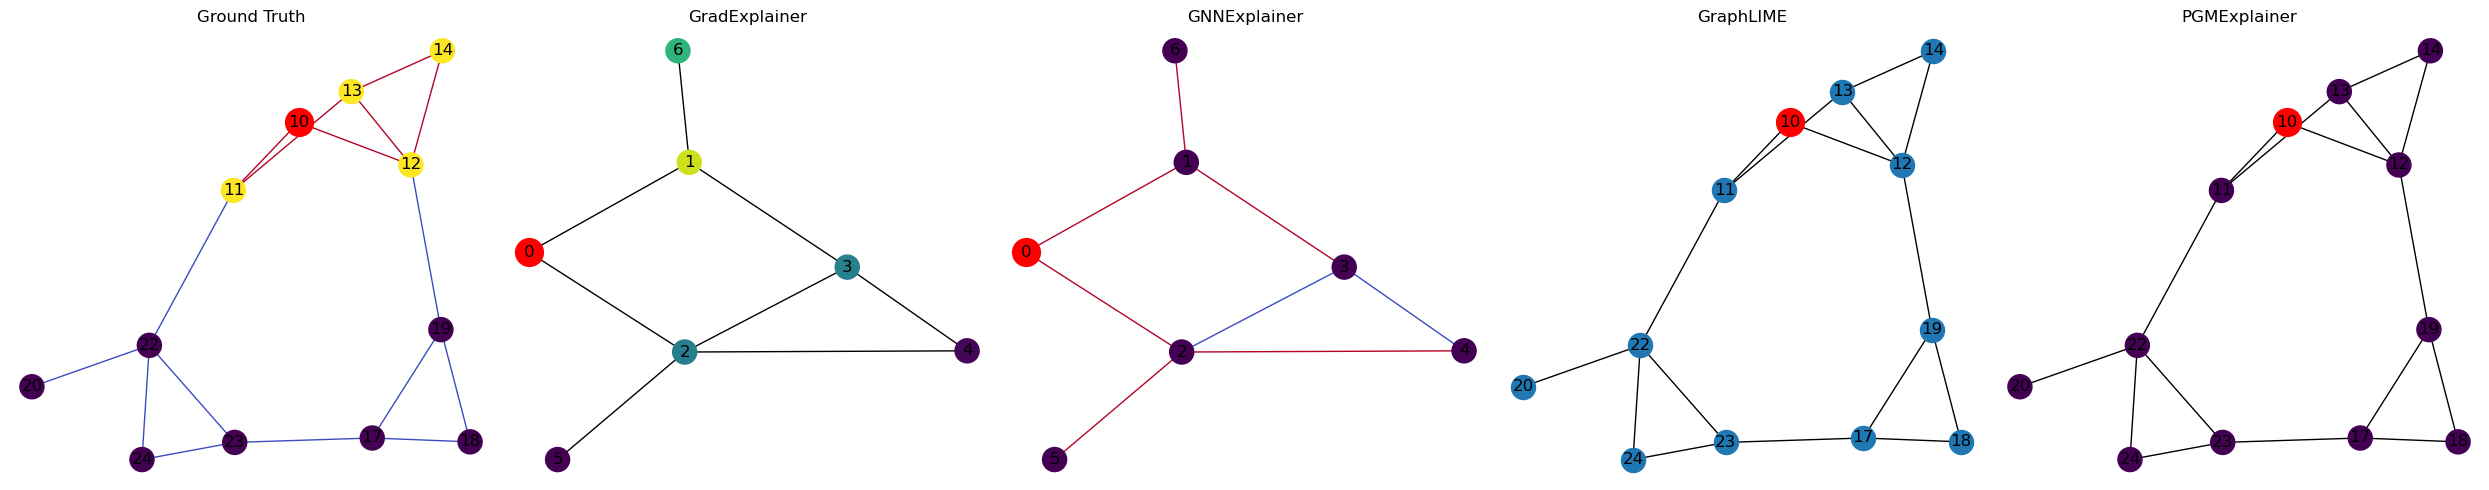

In [26]:
import matplotlib.pyplot as plt
from torch_geometric.data import Data

# Helper untuk ambil subgraf dari enc_subgraph
def get_data_from_explanation(exp, full_data):
    subset = exp.enc_subgraph.nodes
    edge_index = exp.enc_subgraph.edge_index
    return Data(
        x=full_data.x[subset],
        edge_index=edge_index,
        y=full_data.y[subset]
    )

# Pastikan node_idx dalam bentuk int
if isinstance(node_idx, torch.Tensor):
    node_idx = node_idx.item()

# Siapkan subplot 1 baris 5 kolom
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

# 1. Ground Truth dari ShapeGGen
dataset.explanations[node_idx][0].visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[0],
    show_node_labels=True
)
ax[0].set_title("Ground Truth")

# 2. GradExplainer
if isinstance(grad_explanation.node_idx, torch.Tensor):
    grad_explanation.node_idx = grad_explanation.node_idx.item()

graph_for_grad = get_data_from_explanation(grad_explanation, data)
grad_explanation.visualize_node(
    num_hops=2,
    graph_data=graph_for_grad,
    ax=ax[1],
    show_node_labels=True
)
ax[1].set_title("GradExplainer")

# 3. GNNExplainer
if isinstance(gnn_explanation.node_idx, torch.Tensor):
    gnn_explanation.node_idx = gnn_explanation.node_idx.item()

graph_for_gnn = get_data_from_explanation(gnn_explanation, data)
gnn_explanation.visualize_node(
    num_hops=2,
    graph_data=graph_for_gnn,
    ax=ax[2],
    show_node_labels=True
)
ax[2].set_title("GNNExplainer")

# 4. GraphLIME (gunakan graf penuh)
if isinstance(lime_explanation.node_idx, torch.Tensor):
    lime_explanation.node_idx = lime_explanation.node_idx.item()

lime_explanation.visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[3],
    show_node_labels=True
)
ax[3].set_title("GraphLIME")

# 5. PGMExplainer (juga gunakan graf penuh)
if isinstance(pgm_explanation.node_idx, torch.Tensor):
    pgm_explanation.node_idx = pgm_explanation.node_idx.item()

pgm_explanation.visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[4],
    show_node_labels=True
)
ax[4].set_title("PGMExplainer")

# Tata letak rapi
plt.tight_layout()
plt.show()


In [27]:
from graphxai.utils import Explanation, EnclosingSubgraph

class SafeGraphLIME(GraphLIME):
    def get_explanation_node(self, node_idx, x, edge_index, *args, **kwargs):
        self.model = self.model.to(x.device)
        print(f"[SafeGraphLIME] Memulai explain node {node_idx}")
        result = super().get_explanation_node(node_idx, edge_index, x, *args, **kwargs)
        print(f"[SafeGraphLIME] Selesai explain node {node_idx}")
        return result

lime_explainer = SafeGraphLIME(model)

# Update function to handle GraphLIME conversion
def compare_explanations(node_idx, data, explainers, names):
    explanations = []
    for name, explainer in zip(names, explainers):
        if name == 'GraphLIME':
            lime_exp = explainer.get_explanation_node(
                node_idx=node_idx,
                x=data.x,
                edge_index=data.edge_index
            )
            # Konversi feature importance ke node importance
            node_imp = torch.zeros(data.num_nodes)
            node_imp[node_idx] = lime_exp.feature_imp.mean().item()

            # Buat enclosing subgraph info
            subset, sub_edge_index, mapping, _ = k_hop_subgraph(
                node_idx, 2, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes
            )
            edge_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
            for i, (u, v) in enumerate(data.edge_index.t()):
                if u in subset and v in subset:
                    edge_mask[i] = True

            enc_subgraph = EnclosingSubgraph(
                nodes=subset,
                edge_index=sub_edge_index,
                inv=mapping,
                edge_mask=edge_mask,
                directed=False
            )

            lime_exp_final = Explanation(
                node_imp=node_imp,
                node_idx=node_idx
            )
            lime_exp_final.enc_subgraph = enc_subgraph
            lime_exp_final.node_reference = {0: node_idx}

            explanations.append(lime_exp_final)
        else:
            exp = explainer.get_explanation_node(
                node_idx=node_idx,
                x=data.x,
                edge_index=data.edge_index
            )
            explanations.append(exp)

    # Print importance scores
    for name, exp in zip(names, explanations):
        print(f"\n{name} top 5 important nodes:")
        imp_scores = [(i, score) for i, score in enumerate(exp.node_imp)]
        imp_scores.sort(key=lambda x: abs(x[1]), reverse=True)
        for node, score in imp_scores[:5]:
            print(f"Node {node}: {score:.4f}")

# List explainer
explainers = [grad_explainer, gnn_explainer, pgm_explainer, lime_explainer]
names = ['GradExplainer', 'GNNExplainer', 'PGMExplainer', 'GraphLIME']

compare_explanations(node_idx, data, explainers, names)


  0%|          | 0/1000000 [00:00<?, ?it/s]

[SafeGraphLIME] Memulai explain node 10
[SafeGraphLIME] Selesai explain node 10

GradExplainer top 5 important nodes:
Node 0: 0.2436
Node 1: 0.2239
Node 6: 0.1524
Node 3: 0.0949
Node 2: 0.0923

GNNExplainer top 5 important nodes:
Node 0: 1.0000
Node 1: 1.0000
Node 2: 1.0000
Node 3: 1.0000
Node 4: 1.0000

PGMExplainer top 5 important nodes:
Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000
Node 4: 0.0000

GraphLIME top 5 important nodes:
Node 10: 0.0448
Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000



c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
